### Chris Hamm 2019-09-23 (initial code)
A jupyter notebook to add *Neonympha* images from google images. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [3]:
from fastai import *
from fastai.vision import *

In [4]:
np.random.seed(1138)

Now prepare to download the files to our repo

Nar

In [35]:
gimage_path = "../data/images/"

In [29]:
Nar_folder = "Nar"
Nar_file = "Nar_photos.txt"
Nar_path = Path('../data/images/Nar')
Nar_dest = Nar_path/Nar_folder
Nar_dest.mkdir(parents = True, exist_ok = True)

Nmi

In [30]:
Nmi_folder = "Nmi"
Nmi_file = "Nmi_photos.txt"
Nmi_path = Path('../data/images/Nmi')
Nmi_dest = Nmi_path/Nmi_folder
Nmi_dest.mkdir(parents = True, exist_ok = True)

Nfr

In [31]:
Nfr_folder = "Nfr"
Nfr_file = "Nfr_photos.txt"
Nfr_path = Path('../data/images/Nfr')
Nfr_dest = Nfr_path/Nfr_folder
Nfr_dest.mkdir(parents = True, exist_ok = True)

Nhe

In [32]:
Nhe_folder = "Nhe"
Nhe_file = "Nhe_photos.txt"
Nhe_path = Path('../data/images/Nhe')
Nhe_dest = Nhe_path/Nhe_folder
Nhe_dest.mkdir(parents = True, exist_ok = True)

Download the images

In [33]:
classes = ['Nar', 'Nmi', 'Nfr', 'Nhe']

In [34]:
#download_images(Nar_path/Nar_file, Nar_dest, max_pics = 50)
#download_images(Nmi_path/Nmi_file, Nmi_dest, max_pics = 50)
#download_images(Nfr_path/Nfr_file, Nfr_dest, max_pics = 50)
#download_images(Nhe_path/Nhe_file, Nhe_dest, max_pics = 50)

In [58]:
gimage_data = ImageDataBunch.from_folder(path = gimage_path, train = ".", 
                                         valid_pct = 0.2, ds_tfms = get_transforms(),
                                        size = 224, num_workers = 4, bs = 64).normalize(imagenet_stats)

In [59]:
gimage_data

ImageDataBunch;

Train: LabelList (473 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Nar,Nar,Nar,Nar,Nar
Path: ../data/images;

Valid: LabelList (118 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Nar,Nfr,Nmi,Nar,Nmi
Path: ../data/images;

Test: None

In [61]:
print(gimage_data.classes)

['Nar', 'Nfr', 'Nhe', 'Nmi']


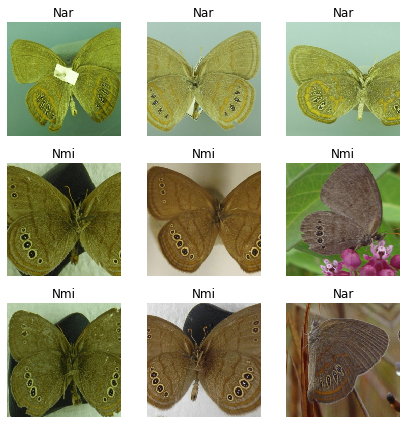

In [62]:
gimage_data.show_batch(rows = 3, figsize = (6, 6))

### `resnet34`

In [63]:
gimage_learn34 = cnn_learner(gimage_data, models.resnet34, metrics = error_rate)

In [64]:
gimage_learn34.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.766694,0.526247,0.169492,00:18
1,1.144574,0.353719,0.144068,00:18
2,0.871384,0.259346,0.076271,00:18
3,0.716489,0.256692,0.076271,00:18


In [50]:
ginterpretation34 = ClassificationInterpretation.from_learner(gimage_learn34)

glosses34, gidxs34 = ginterpretation34.top_losses()

len(gimage_data.valid_ds) == len(glosses34) == len(gidxs34)

True

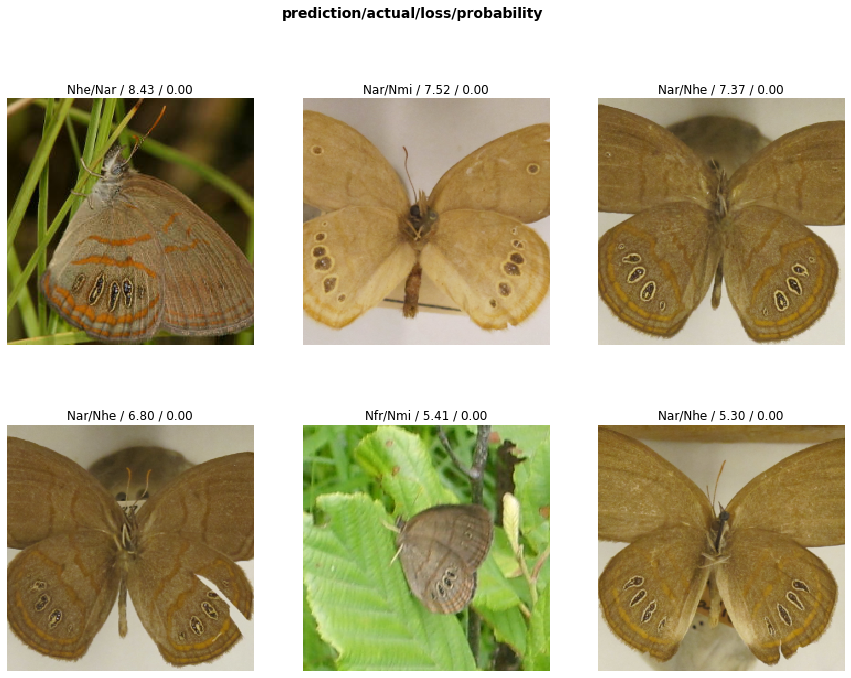

In [51]:
ginterpretation34.plot_top_losses(6, figsize = (15, 11))

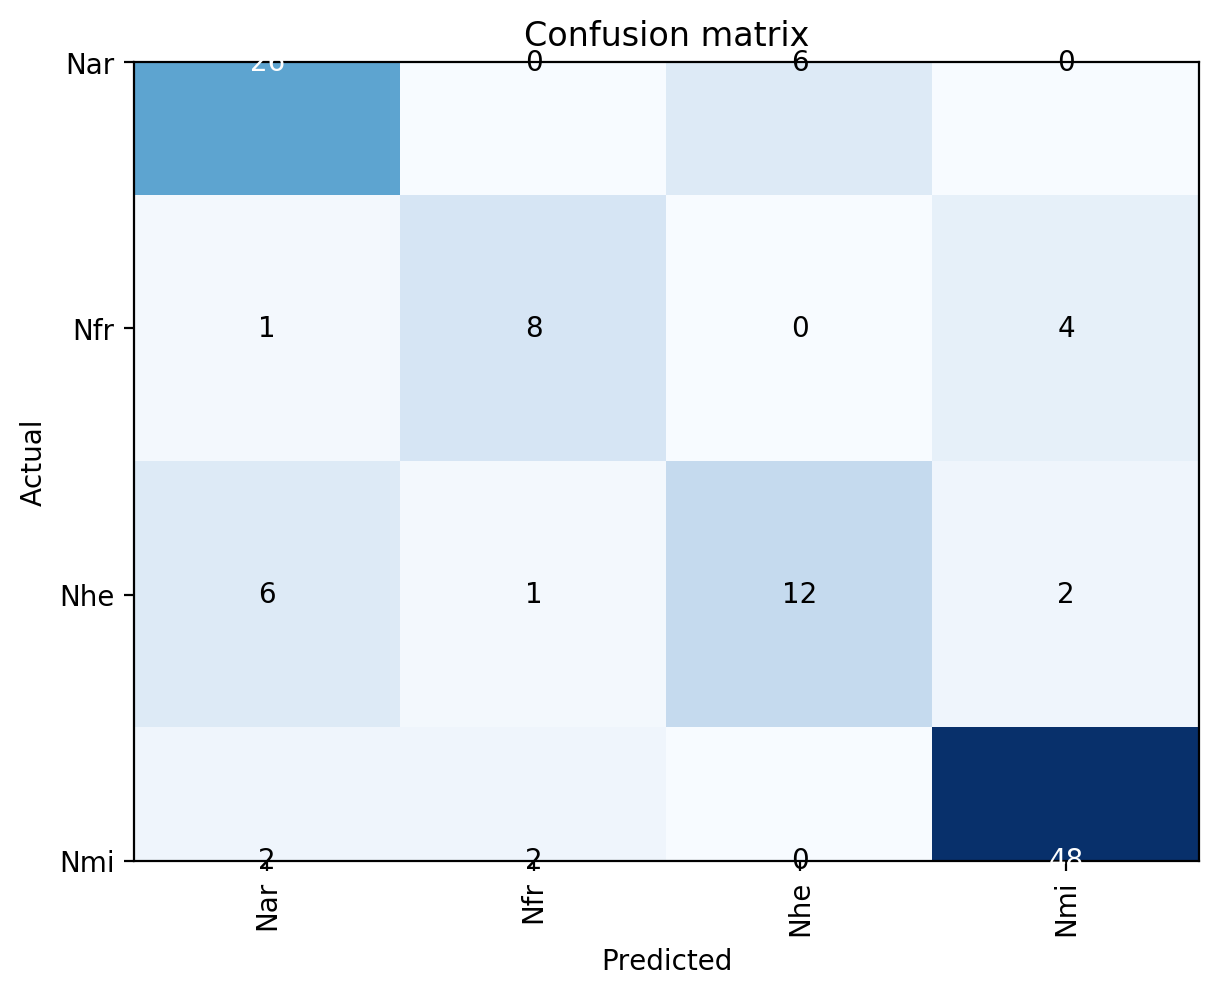

In [65]:
ginterpretation34.plot_confusion_matrix(figsize = (6, 6), dpi = 200)

In [66]:
ginterpretation34.most_confused(min_val = 0) 

[('Nar', 'Nhe', 6),
 ('Nhe', 'Nar', 6),
 ('Nfr', 'Nmi', 4),
 ('Nhe', 'Nmi', 2),
 ('Nmi', 'Nar', 2),
 ('Nmi', 'Nfr', 2),
 ('Nfr', 'Nar', 1),
 ('Nhe', 'Nfr', 1),
 ('Nar', 'Nar', 0),
 ('Nar', 'Nfr', 0),
 ('Nar', 'Nmi', 0),
 ('Nfr', 'Nfr', 0),
 ('Nfr', 'Nhe', 0),
 ('Nhe', 'Nhe', 0),
 ('Nmi', 'Nhe', 0),
 ('Nmi', 'Nmi', 0)]

### `resnet50`

In [54]:
gimage_learn50 = cnn_learner(gimage_data, models.resnet50, metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 10.9MB/s]


In [55]:
gimage_learn50.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.542821,0.908828,0.305085,00:20
1,1.036890,0.560360,0.169492,00:19
2,0.779029,0.641227,0.144068,00:18
3,0.620904,0.536763,0.127119,00:19


In [56]:
ginterpretation50 = ClassificationInterpretation.from_learner(gimage_learn50)

glosses50, gidxs50 = ginterpretation50.top_losses()

len(gimage_data.valid_ds) == len(glosses50) == len(gidxs50)

True

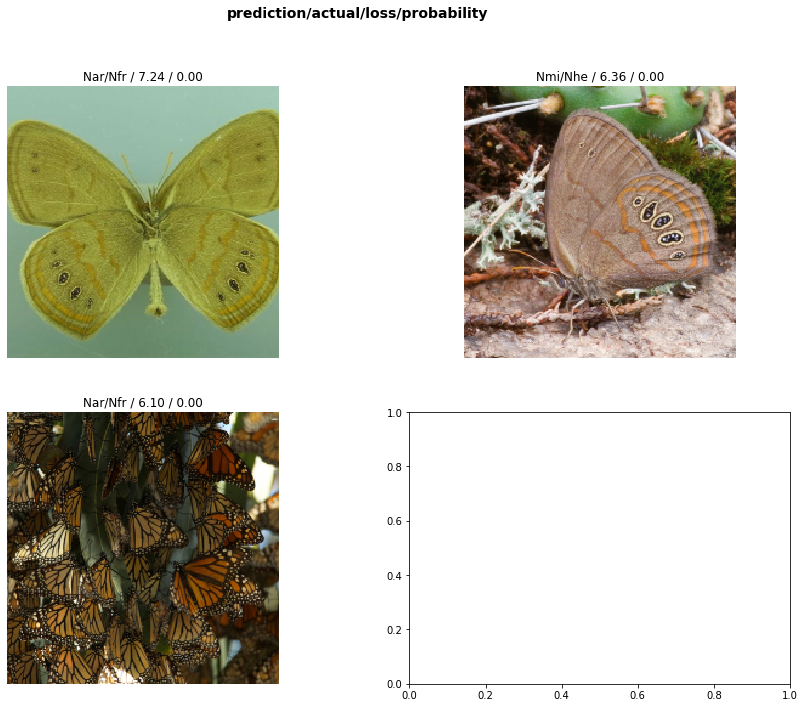

In [57]:
ginterpretation50.plot_top_losses(4, figsize = (15, 11))

In [ ]:
ginterpretation34.most_confused(min_val = 0) 